INSTALLING ALL LIBRARIES

In [5]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
%matplotlib inline
sns.set(style='whitegrid',palette='muted',font_scale=1.5)
random_seed=42

ENSURING THE DATA 

In [6]:
columns=['user','activity','timestamp','x-axis','y-axis','z-axis']
df = pd.read_csv('C:/Users/Sriman Reddy/OneDrive/Desktop/AIML LAB/AIML datasets/WISDM_ar_v1.1_raw.txt',names=columns)
df.head()

,user,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1098204 entries, 0 to 1098203
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user       1098204 non-null  int64  
 1   activity   1098204 non-null  object 
 2   timestamp  1098204 non-null  int64  
 3   x-axis     1098204 non-null  float64
 4   y-axis     1098204 non-null  float64
 5   z-axis     1098203 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 50.3+ MB


EXPLORATION OF DATA

In [8]:
count_of_activity=df['activity'].value_counts()
print(count_of_activity)

Walking       424398
Jogging       342176
Upstairs      122869
Downstairs    100427
Sitting        59939
Standing       48395
Name: activity, dtype: int64


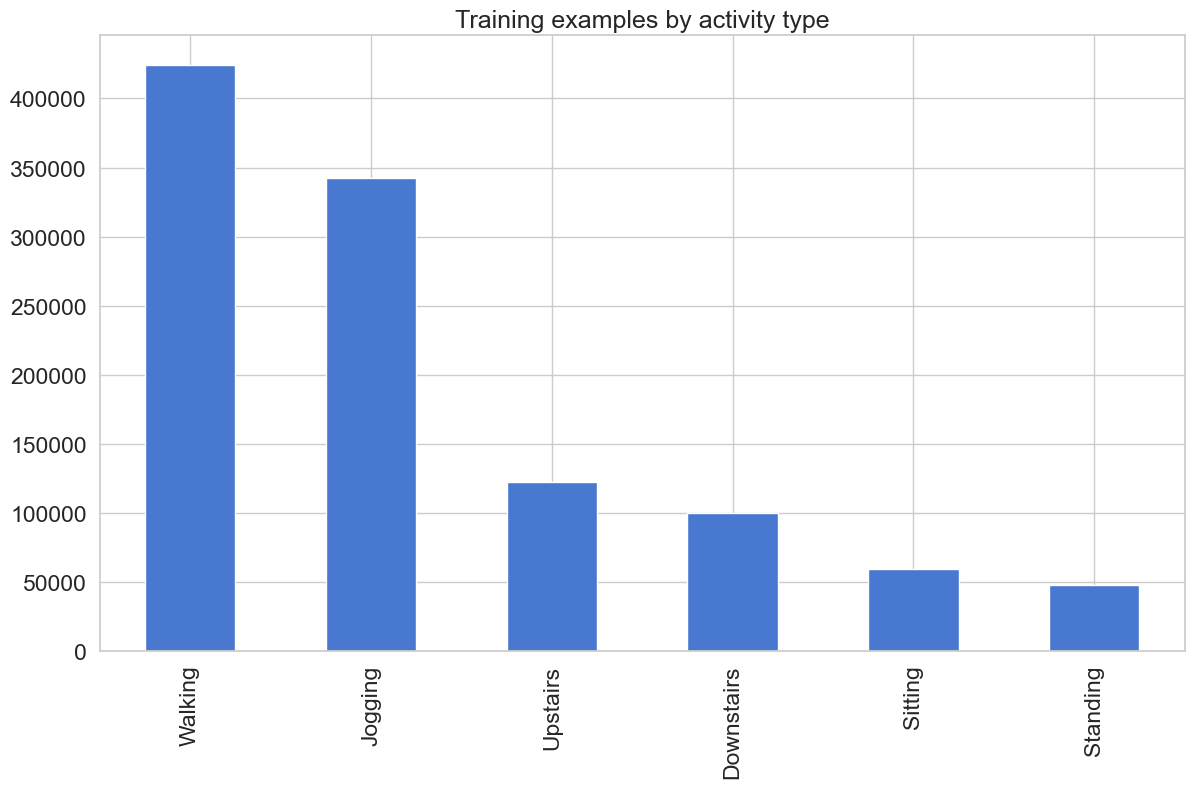

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
count_of_activity.plot(kind='bar', title='Training examples by activity type', figsize=(14, 8))
plt.show()


NO.OF SAMPLES BELONGING TO EACH VOLUNTEER

In [10]:
count_of_Activity_per_person=df['user'].value_counts()
print(count_of_Activity_per_person)
total_activity=count_of_Activity_per_person.sum()
print("total number of activity recorded="+str(total_activity))

20    56632
19    45383
31    44282
8     41188
29    38245
14    38192
13    37093
34    35947
32    35506
21    35436
3     35161
27    34958
10    34883
18    32811
12    32641
26    32578
36    32261
11    31659
7     30967
1     29978
6     29704
33    29453
5     28509
15    28154
24    25736
23    25673
30    25335
2     23525
35    22394
22    22310
17    22020
28    21358
16    20470
25    13468
9     12923
4     11371
Name: user, dtype: int64
total number of activity recorded=1098204


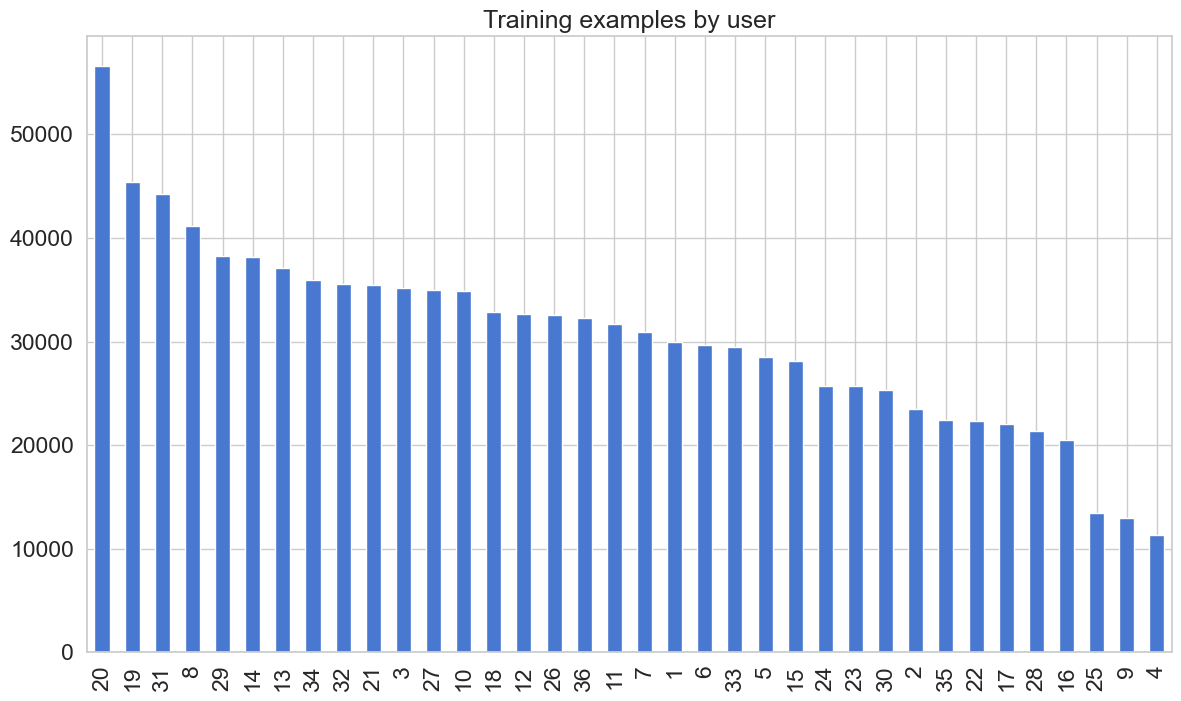

In [11]:
count_of_Activity_per_person.plot(kind='bar',title='Training examples by user',figsize=(14,8));

HOW DOES THE ACCELEROMETER DATA LOOKS LIKE VISUALLY

PLOTTING THE ACTIVITIES 

In [12]:
def plot_activity(activity, df):
    # Convert the activity name to lowercase for consistency
    activity = activity.lower()
    
    # Filter rows based on the activity
    data = df[df['activity'].str.lower() == activity]
    
    # If no data is found for the specified activity, print a message and return
    if data.empty:
        print(f"No data found for activity: {activity.capitalize()}")
        return
    
    # Select only the accelerometer data columns and limit to the first 200 rows
    data = data[['x-axis', 'y-axis', 'z-axis']][:200]
    
    # Plot the accelerometer data
    ax = data.plot(subplots=True, figsize=(14, 8), title=activity.capitalize())


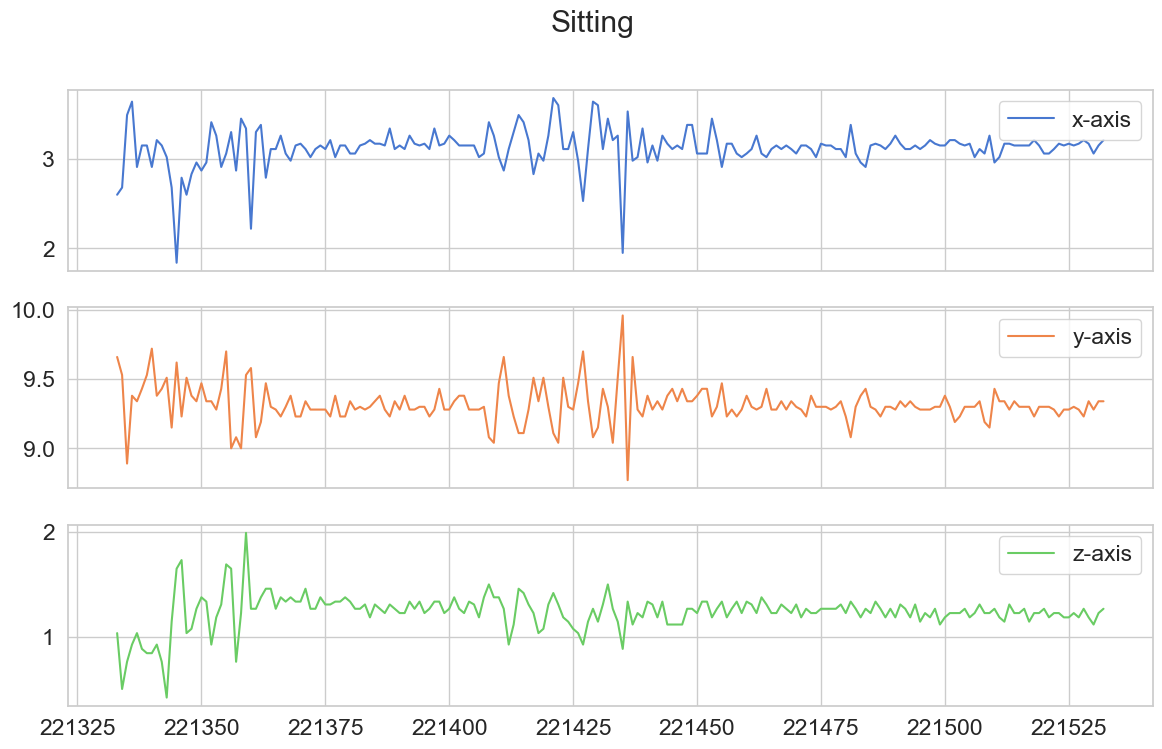

In [13]:
plot_activity('sitting',df)

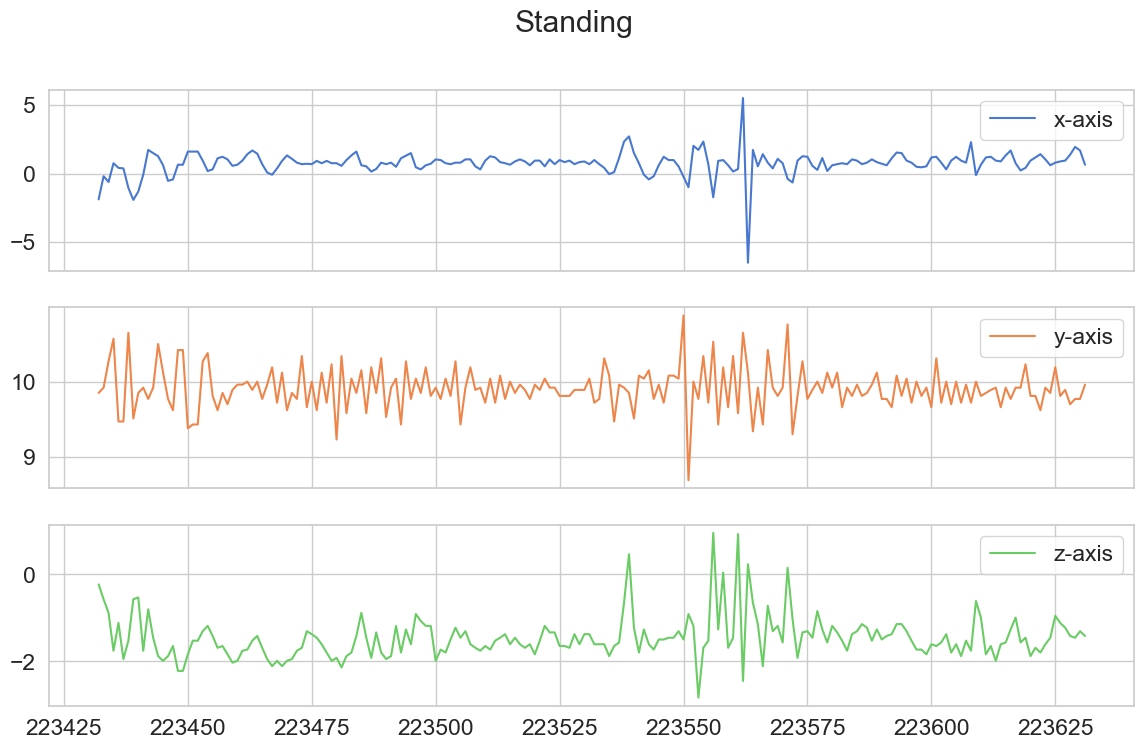

In [14]:
plot_activity('standing',df)

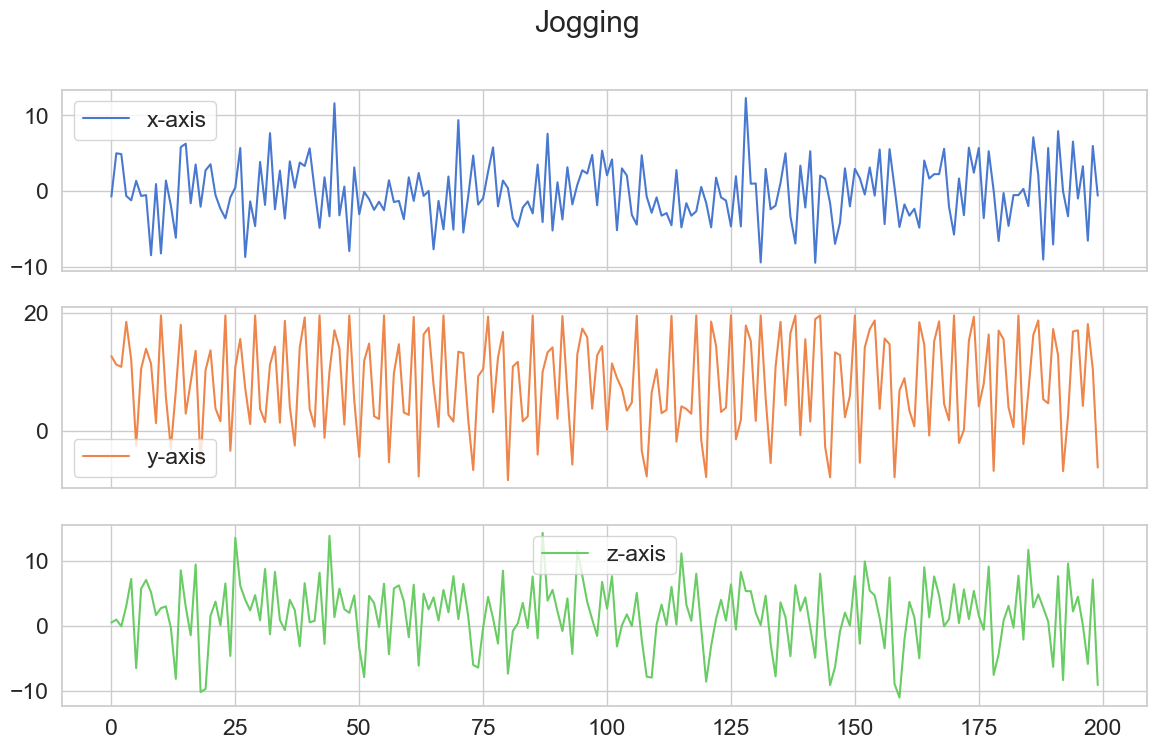

In [15]:
plot_activity('jogging',df)

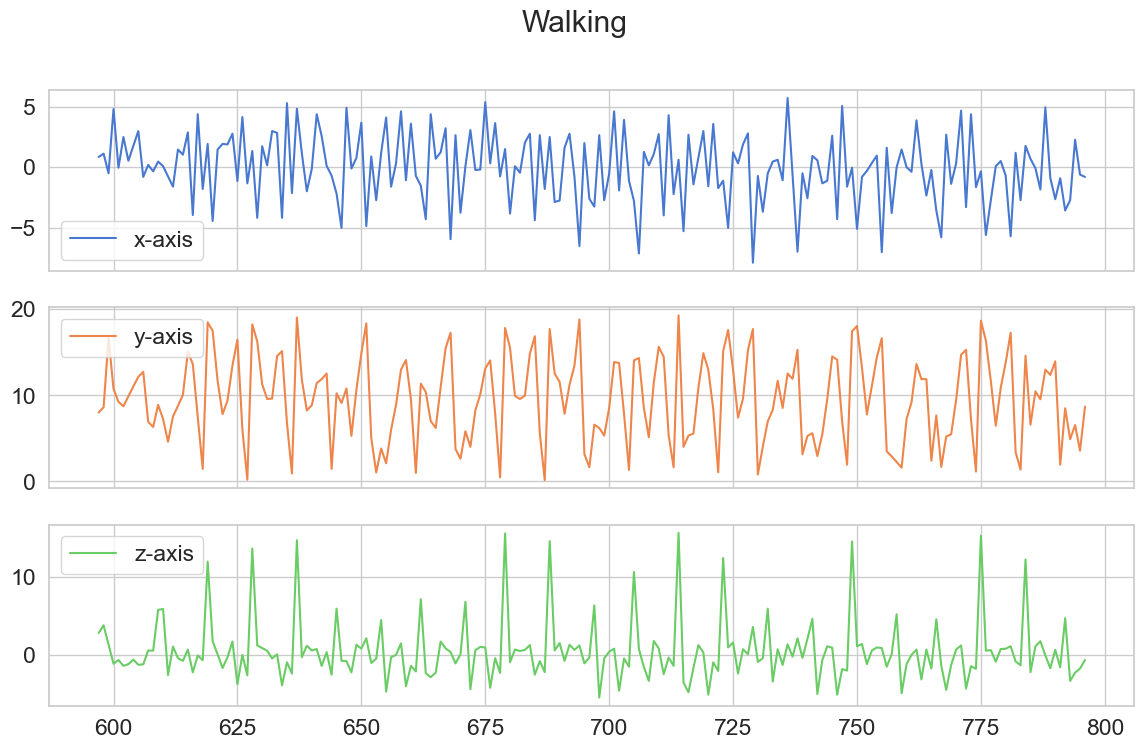

In [16]:
plot_activity('walking',df)

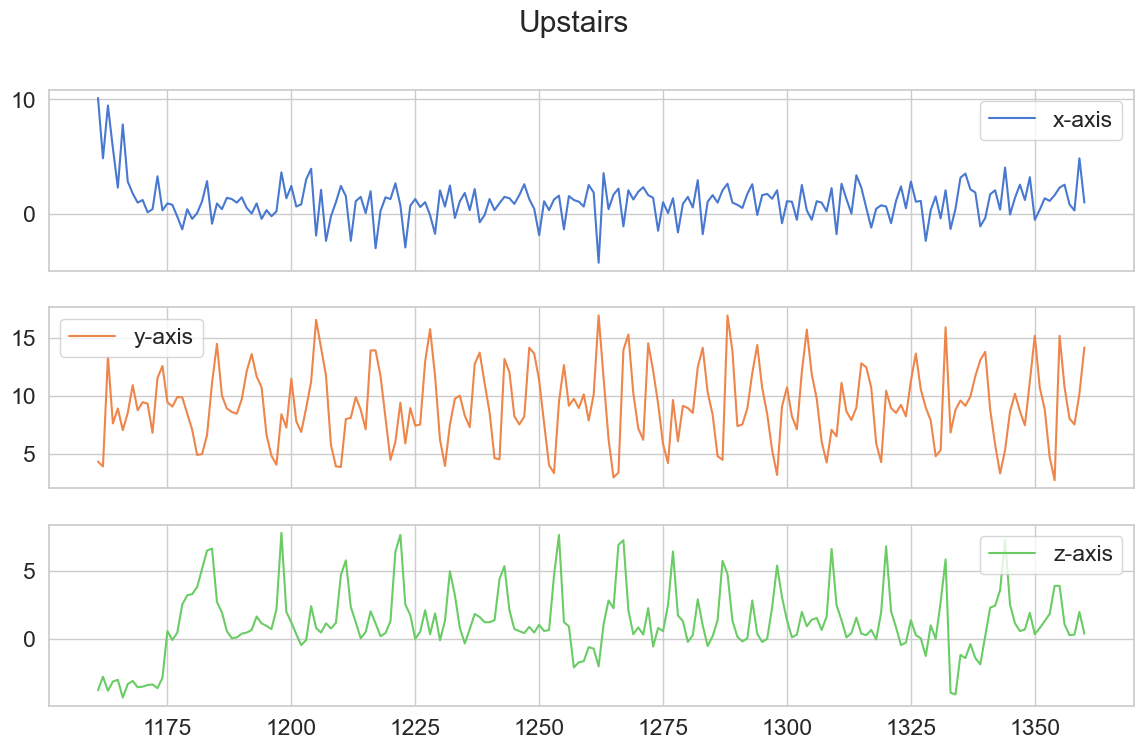

In [17]:
plot_activity('upstairs',df)

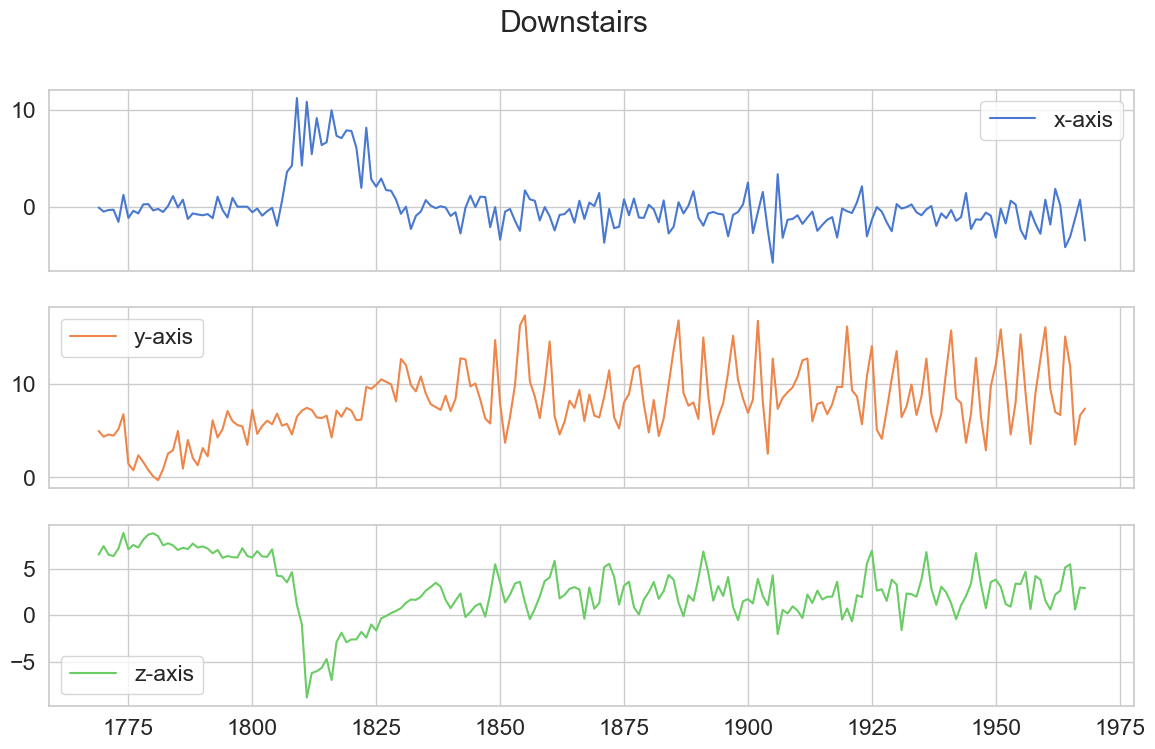

In [18]:
plot_activity('downstairs',df)

DATA PREPROCESSING

- modelling time series
- LSTM RNN
- 200 TRAINING SAMPLE SEQUENCE
- DIVIDING THE WHOLE DATA INTO MULTIPLE TIME SLICES

In [19]:
import numpy as np

n_time_steps = 200
n_features = 3
step = 20
segments = []
labels = []

for i in range(0, len(df) - n_time_steps, step):
    xs = df['x-axis'].values[i:i + n_time_steps]
    ys = df['y-axis'].values[i:i + n_time_steps]
    zs = df['z-axis'].values[i:i + n_time_steps]
    segment = np.column_stack((xs, ys, zs))  # Combine xs, ys, zs into one array
    segments.append(segment)
    label = stats.mode(df['activity'][i:i + n_time_steps])
    label = label[0][0]
    labels.append(label)

segments = np.asarray(segments, dtype=np.float32)
labels = np.asarray(labels)

print(segments.shape)



(54901, 200, 3)


In [20]:
np.array(segments).shape

(54901, 200, 3)

TRANSFORMING THE SHAPES OF SEGMENTS

In [21]:
reshaped_segments=np.asarray(segments,dtype=np.float32).reshape(-1,n_time_steps,n_features)
reshaped_segments.shape

(54901, 200, 3)

ONE HOT !! ENCODING OF LABELS(WALKING,SITTING,JOGGING etc..)

In [22]:
labels=np.array(pd.get_dummies(labels),dtype=np.float32)

In [23]:
print(labels)
print(labels.shape)

[[0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]
(54901, 6)


Finally,let's split the data into training and test(20%) set:

In [24]:
x_train, x_test, y_train, y_test = train_test_split(
    reshaped_segments, labels, test_size=0.2, random_state=random_seed)

In [25]:
len(x_train)

43920

In [26]:
len(x_test)

10981

BUILDING THE MODEL
- 2 fully connected and 2 LSTM layers
- 64 units each

In [27]:
n_classes=6
n_hidden_units=64 #LSTM LAYERS
n_time_steps=200
n_features=3

# Placeholder for input data
inputs = tf.placeholder(tf.float32, [None, n_time_steps, n_features])

# Placeholder for labels
labels = tf.placeholder(tf.float32, [None, n_classes])

# Placeholder for dropout keep probability (if needed)
keep_prob = tf.placeholder(tf.float32)

# Placeholder for learning rate (if needed)
learning_rate = tf.placeholder(tf.float32)

# Placeholder for initial state of LSTM (if using LSTM layers)
initial_state = tf.placeholder(tf.float32, [None, n_hidden_units * 2])

# Define weights and biases for hidden layer
W_hidden = tf.Variable(tf.random_normal([n_features, n_hidden_units]))
b_hidden = tf.Variable(tf.random_normal([n_hidden_units]))

# Define weights and biases for output layer
W_output = tf.Variable(tf.random_normal([n_hidden_units, n_classes]))
b_output = tf.Variable(tf.random_normal([n_classes]))


In [28]:
def create_LSTM_model(inputs):
      # Define weights and biases for hidden layer
    W_hidden = tf.Variable(tf.random_normal([n_features, n_hidden_units]))
    b_hidden = tf.Variable(tf.random_normal([n_hidden_units]))

    # Define weights and biases for output layer
    W_output = tf.Variable(tf.random_normal([n_hidden_units, n_classes]))
    b_output = tf.Variable(tf.random_normal([n_classes]))

    # Example usage of inputs
    x = tf.transpose(inputs, [1, 0, 2])
    x = tf.reshape(x, [-1, n_features])
    hidden = tf.nn.relu(tf.matmul(x, W_hidden) + b_hidden)
    hidden = tf.split(hidden, n_time_steps, 0)

    # Example computation
    lstm_last_output = hidden[-1]
    output = tf.matmul(lstm_last_output, W_output) + b_output

    return output



Creating Placeholders :

In [29]:
tf.reset_default_graph()

X=tf.placeholder(tf.float32,[None , n_time_steps,n_features],name="input")
Y=tf.placeholder(tf.float32,[None ,n_classes])

CREATING THE MODEL

In [30]:
pred_Y=create_LSTM_model(X)
pred_softmax=tf.nn.softmax(pred_Y,name="y_")

In [31]:
L2_LOSS = 0.0015
l2=L2_LOSS * \
        sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred_Y , labels =Y)) +12



Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



Optimizer and accuracy :

In [32]:
LEARNING_RATE =0.0025

optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

correct_pred = tf.equal(tf.argmax(pred_softmax,1),tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred , dtype=tf.float32))

In [33]:
N_EPOCHS=50
BATCH_SIZE=1024

In [34]:
saver = tf.train.Saver()
history = dict(train_loss=[],
               train_acc=[],
               test_loss=[],
               test_acc=[])
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
train_count = len(x_train)

for i in range(1, N_EPOCHS + 1):
    for start, end in zip(range(0, train_count, BATCH_SIZE),
                          range(BATCH_SIZE, train_count + 1, BATCH_SIZE)):
        sess.run(optimizer, feed_dict={X: x_train[start:end],
                                       Y: y_train[start:end]})
    acc_train, loss_train = sess.run([accuracy, loss], feed_dict={X: x_train, Y: y_train})
    acc_test, loss_test = sess.run([accuracy, loss], feed_dict={X: x_test, Y: y_test})
    history['train_loss'].append(loss_train)
    history['train_acc'].append(acc_train)
    history['test_loss'].append(loss_test)
    history['test_acc'].append(acc_test)
    
    if i!= 1 and i % 10!= 0:
        continue
    print(f'epoch: {i} test accuracy: {acc_test*100}% loss: {loss_test}')

predictions, acc_final, loss_final = sess.run([pred_softmax, accuracy, loss], feed_dict={X: x_test, Y: y_test})

print()
print(f'final results: accuracy: {acc_final*100}% loss: {loss_final}')




epoch: 1 test accuracy: 9.634824097156525% loss: nan
epoch: 10 test accuracy: 9.634824097156525% loss: nan
epoch: 20 test accuracy: 9.634824097156525% loss: nan
epoch: 30 test accuracy: 9.634824097156525% loss: nan
epoch: 40 test accuracy: 9.634824097156525% loss: nan
epoch: 50 test accuracy: 9.634824097156525% loss: nan

final results: accuracy: 9.634824097156525% loss: nan


FINDING ACCURACY USING LOGISTIC REGRESSION

In [46]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Load the dataset
dataset_path = "C:/Users/Sriman Reddy/OneDrive/Desktop/AIML LAB/AIML datasets/WISDM_ar_v1.1_raw.txt"
column_names = ['user_id', 'activity', 'timestamp', 'x_acceleration', 'y_acceleration', 'z_acceleration']
data = pd.read_csv(dataset_path, header=None, names=column_names)

# Drop rows with NaN values
data.dropna(inplace=True)

# Data preprocessing
X = data[['x_acceleration', 'y_acceleration', 'z_acceleration']]
y = data['activity']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the Logistic Regression classifier
logistic_regression = LogisticRegression(max_iter=1000, random_state=42)

# Train the classifier
logistic_regression.fit(X_train_scaled, y_train)

# Evaluate the classifier on the test set
y_pred = logistic_regression.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'accuracy :{accuracy*100}%')


accuracy :47.61906929944774%


FINDING ACCURACY USING RANDOM FOREST

In [44]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score

# Load the dataset
dataset_path = "C:/Users/Sriman Reddy/OneDrive/Desktop/AIML LAB/AIML datasets/WISDM_ar_v1.1_raw.txt"
column_names = ['user_id', 'activity', 'timestamp', 'x_acceleration', 'y_acceleration', 'z_acceleration']
data = pd.read_csv(dataset_path, header=None, names=column_names)

# Drop rows with NaN values
data.dropna(inplace=True)

# Data preprocessing
X = data[['x_acceleration', 'y_acceleration', 'z_acceleration']]
y = data['activity']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Impute missing values with mean for features
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Convert y_train and y_test to arrays
y_train_array = y_train.values
y_test_array = y_test.values

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_train_scaled, y_train_array)

# Evaluate the classifier on the test set
y_pred = rf_classifier.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test_array, y_pred)
print(f'accuracy :{accuracy*100}%')


accuracy :63.98258977149075%


COMPARING ACCURACY BETWEEN LSTM / RANDOM FOREST / LOGISTIC REGRESSION

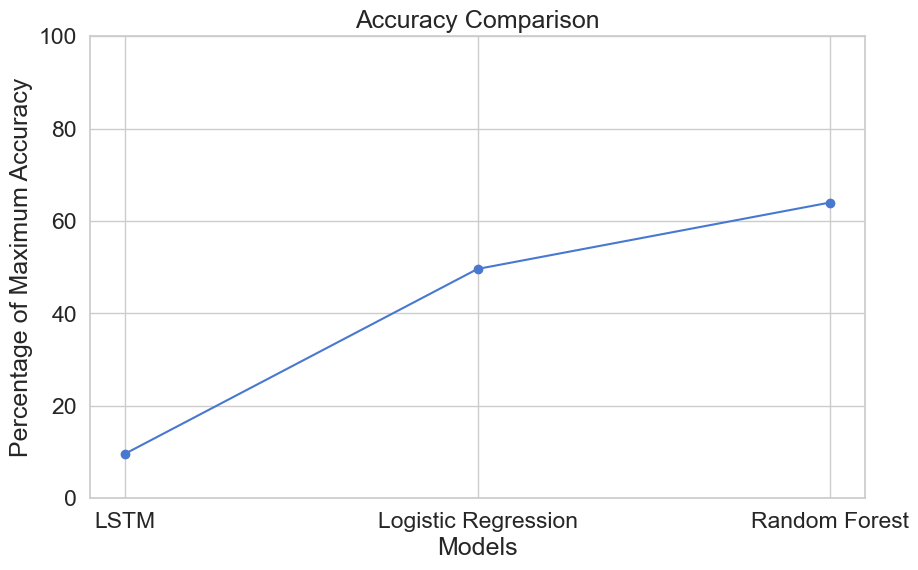

In [57]:
accuracy_lstm = 0.0963 
accuracy_rf=0.6398
accuracy_lr=0.4961

max_accuracy = max(accuracy_lstm, accuracy_rf, accuracy_lr)
percent_lstm = accuracy_lstm * 100
percent_rf = accuracy_rf * 100
percent_lr = accuracy_lr * 100

# Plotting
models = ['LSTM', 'Logistic Regression', 'Random Forest']
percentages = [percent_lstm, percent_lr, percent_rf]

plt.figure(figsize=(10, 6))
plt.plot(models, percentages, marker='o', linestyle='-')
plt.title('Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Percentage of Maximum Accuracy')
plt.ylim(0, 100)  # Limit y-axis to the range [0, 100] for percentages
plt.grid(True)
plt.show()

-  By this we can conclude that random forest has highest accuracy i.e 63.9%


let's  perform confusion matrix

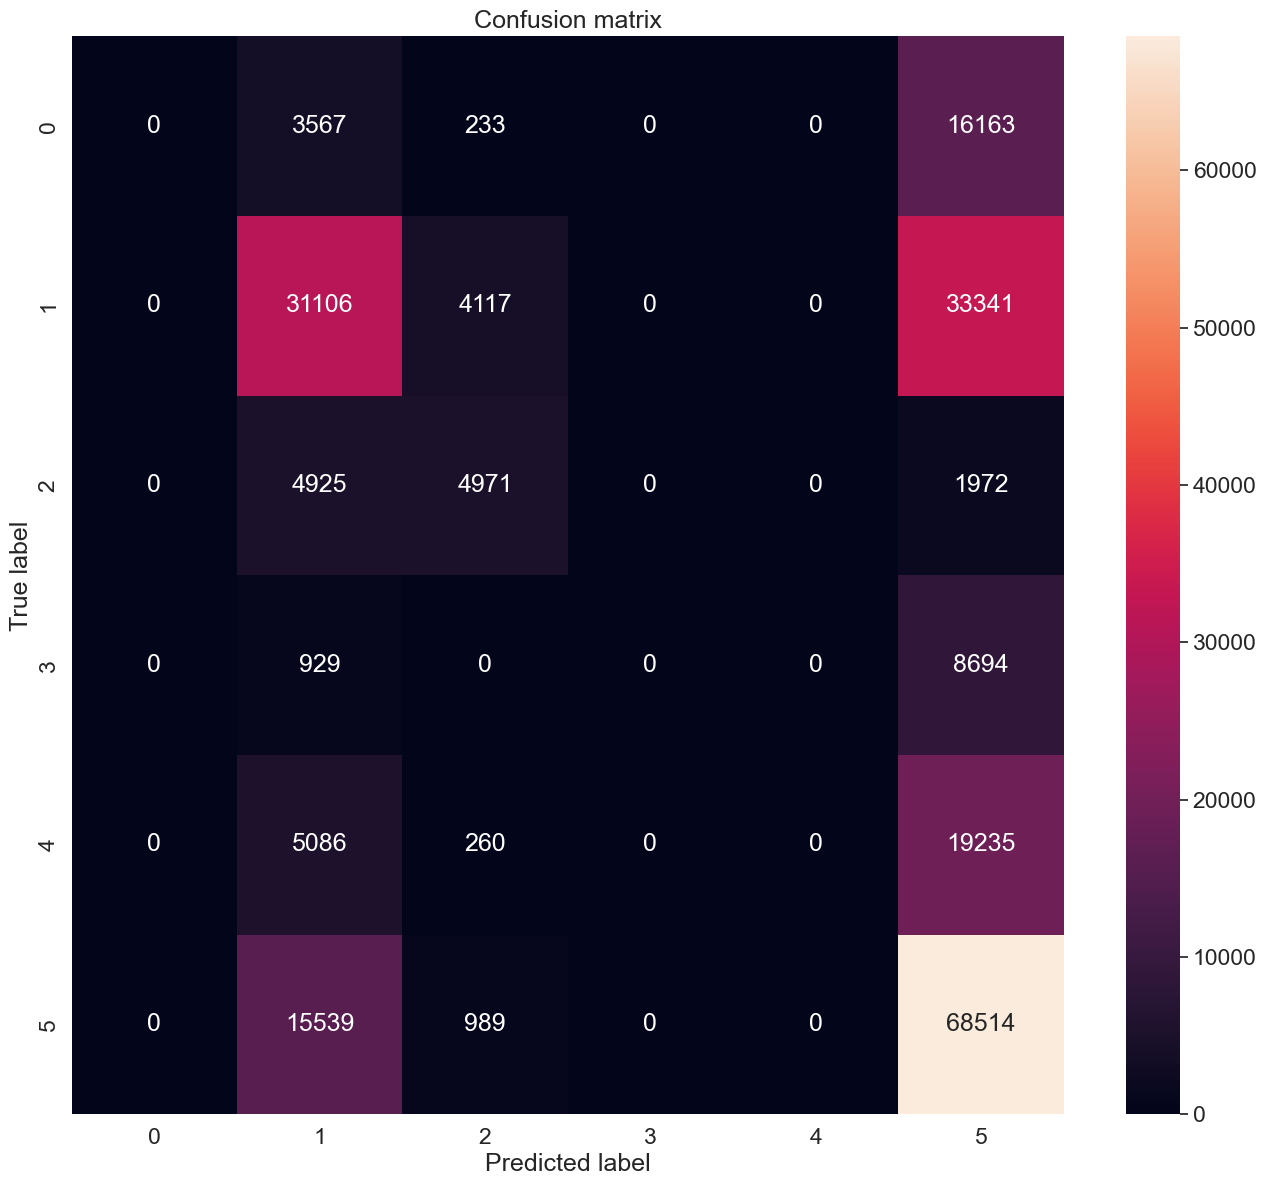

In [50]:
y_pred = logistic_regression.predict(X_test_scaled)
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(16, 14))
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

let's perform corellation matrix 

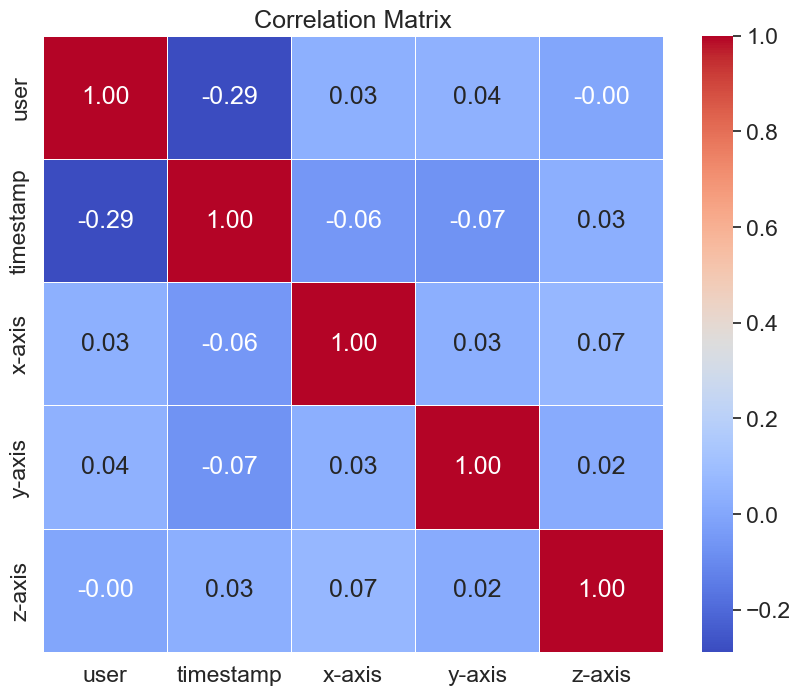

In [66]:
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()